In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

In [4]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        out, _ = self.rnn(x)  # out: (batch_size, seq_len, hidden_size)
        # 取序列最后一个时间步的输出作为模型的输出
        out = out[:, -1, :]  # (batch_size, hidden_size)
        out = self.fc(out)  # 全连接层
        return out


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# 数据集：字符序列预测（Hello -> Elloh）
char_set = list("hello")
char_to_idx = {c: i for i, c in enumerate(char_set)}
idx_to_char = {i: c for i, c in enumerate(char_set)}

print(f"char_to_idx: {char_to_idx}")
print(f"idx_to_char: {idx_to_char}")

# 数据准备
input_str = "hello"
target_str = "elloh"
input_data = [char_to_idx[c] for c in input_str]
target_data = [char_to_idx[c] for c in target_str]

print(f"input_data: {input_data}")
print(f"target_data: {target_data}")

# 转换为独热编码
input_one_hot = np.eye(len(char_set))[input_data]

# 转换为 PyTorch Tensor
inputs = torch.tensor(input_one_hot, dtype=torch.float32)
targets = torch.tensor(target_data, dtype=torch.long)

# 模型超参数
input_size = len(char_set)
hidden_size = 8
output_size = len(char_set)
num_epochs = 200
learning_rate = 0.1

# 定义 RNN 模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)  # 应用全连接层
        return out, hidden

model = RNNModel(input_size, hidden_size, output_size)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练 RNN
losses = []
hidden = None  # 初始隐藏状态为 None
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # 前向传播
    outputs, hidden = model(inputs.unsqueeze(0), hidden)
    hidden = hidden.detach()  # 防止梯度爆炸

    # 计算损失
    loss = criterion(outputs.view(-1, output_size), targets)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# 测试 RNN
with torch.no_grad():
    test_hidden = None
    test_output, _ = model(inputs.unsqueeze(0), test_hidden)
    predicted = torch.argmax(test_output, dim=2).squeeze().numpy()

    print("Input sequence: ", ''.join([idx_to_char[i] for i in input_data]))
    print("Predicted sequence: ", ''.join([idx_to_char[i] for i in predicted]))

char_to_idx: {'h': 0, 'e': 1, 'l': 3, 'o': 4}
idx_to_char: {0: 'h', 1: 'e', 2: 'l', 3: 'l', 4: 'o'}
input_data: [0, 1, 3, 3, 4]
target_data: [1, 3, 3, 4, 0]
Epoch [20/200], Loss: 0.0093
Epoch [40/200], Loss: 0.0010
Epoch [60/200], Loss: 0.0005
Epoch [80/200], Loss: 0.0004
Epoch [100/200], Loss: 0.0003
Epoch [120/200], Loss: 0.0003
Epoch [140/200], Loss: 0.0003
Epoch [160/200], Loss: 0.0002
Epoch [180/200], Loss: 0.0002
Epoch [200/200], Loss: 0.0002
Input sequence:  hello
Predicted sequence:  elloh


In [14]:
import torch
import torch.nn as nn

# 假设有一个词表大小 1000，每个词用 5 维向量表示
vocab_size = 1000
embedding_dim = 5
hidden_size = 16
seq_len = 10
batch_size = 32

# 1. 词嵌入层：把词ID转换成向量
embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# 2. RNN层：处理序列
rnn = nn.RNN(input_size=embedding_dim, hidden_size=hidden_size, batch_first=True)

# 3. 输出层：把RNN输出的隐藏状态映射回词表大小，得到每个词的预测概率
fc = nn.Linear(hidden_size, vocab_size)

# === 模拟输入：32个句子，每句10个词，用词ID表示 ===
# 随机生成词ID，每个ID范围在 [0, vocab_size-1]
x = torch.randint(low=0, high=vocab_size, size=(batch_size, seq_len))  # [32, 10]

print("原始词ID形状:", x.shape)

# 1. 词ID -> 词向量
x_embed = embedding(x)  # [32, 10, 5]
print("词向量形状:", x_embed.shape)

# 2. 输入RNN
output, h_n = rnn(x_embed)  # output: [32, 10, 16]
print("RNN输出形状:", output.shape)

# 3. 预测下一个词：对每个时间步的输出都预测
logits = fc(output)  # [32, 10, 1000]
print("logits形状:", logits.shape)

# 4. 转成概率分布
probs = torch.softmax(logits, dim=-1)  # [32, 10, 1000]
print("预测概率分布形状:", probs.shape)

# 如果只预测最后一个时间步的下一个词，可以取 output[:, -1, :]
last_logits = fc(output[:, -1, :])  # [32, 1000]
last_probs = torch.softmax(last_logits, dim=-1)
print("最后一个词的预测概率分布形状:", last_probs.shape)


原始词ID形状: torch.Size([32, 10])
词向量形状: torch.Size([32, 10, 5])
RNN输出形状: torch.Size([32, 10, 16])
logits形状: torch.Size([32, 10, 1000])
预测概率分布形状: torch.Size([32, 10, 1000])
最后一个词的预测概率分布形状: torch.Size([32, 1000])


## 图像增强

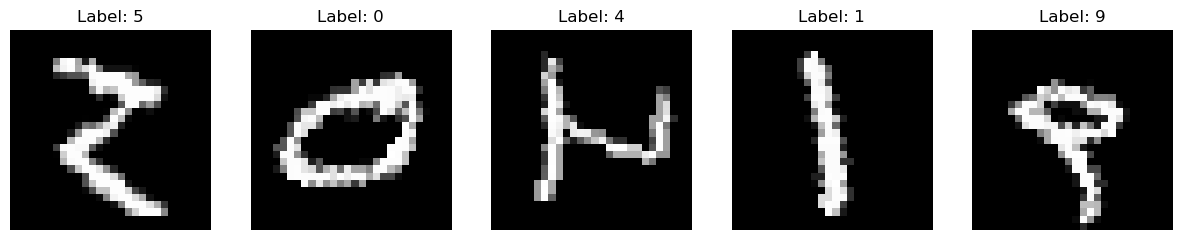

In [15]:
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import datasets, transforms


# 原始和增强后的图像可视化
transform_augment = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor()
])

# 加载数据集
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_augment)

# 显示图像
def show_images(dataset):
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        image, label = dataset[i]
        axs[i].imshow(image.squeeze(0), cmap='gray')  # 将 (1, H, W) 转为 (H, W)
        axs[i].set_title(f"Label: {label}")
        axs[i].axis('off')
    plt.show()

show_images(dataset)